# 모듈 불러오기

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
!pip install pmdarima
!pip install finance-datareader

In [52]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = 12, 12   # 그래프 크기
plt.rcParams['axes.unicode_minus'] = False   # 음수에서 폰트 깨지는거 방지


%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
fontpath = r"/content/drive/MyDrive/python/16. Time Series analysis/주식/삼프로/NanumBarunGothic.ttf"
font = fm.FontProperties(fname=fontpath, size=14)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [53]:
import os
import pandas as pd

import FinanceDataReader as fdr
from pandas_datareader import data 

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima

import itertools
from IPython.display import Image
# import warnings
# warnings.filterwarnings('ignore')

# 데이터 불러오기

## 주가 데이터
  - 상장 법인 목록에서 종목코드를 통해 기업 주가 다운로드
  - 최근 5년간 주식 관련 정보에 대한 시계열 데이터

In [54]:
df_krx = fdr.StockListing('KRX')

# KRX : KOSPI, KOSDAQ, KONEX
# NASDAQ : 나스닥
# NYSE : 뉴욕 증권거래소
# AMEX : AMEX
# SP500 : S&P500

df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,"박종익, 김세완 (각자 대표이사)",http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,박대현,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [55]:
종목 = '골프존'

In [56]:
# df = fdr.DataReader('종목코드','시작일자','종료일자')

# KS11 : KOSPI 지수 
# KQ11 : KOSDAQ 지수
# KS200 : 코스피 200
# DJI : 다우존스 지수
# IXIC : 나스닥 지수
# US500 : S&P 500 지수
# USD/KRW : 달러당 원화 환율 

df = fdr.DataReader('215000','2020')
df['Change'] = df['Change']*100

In [57]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,68100,68100,66200,67200,14596,-2.467344
2020-01-03,67800,68000,66300,66500,12042,-1.041667
2020-01-06,67500,67500,64000,64700,14359,-2.706767
2020-01-07,64200,65800,64200,65100,8415,0.618238
2020-01-08,65100,65100,63200,63300,11221,-2.764977
...,...,...,...,...,...,...
2022-01-10,182500,184000,176000,182500,69781,1.108033
2022-01-11,182200,183200,179100,182400,28136,-0.054795
2022-01-12,183500,188400,181600,185000,88911,1.425439


In [58]:
df_KOSPI = fdr.DataReader('KS11', '2020')
df_KOSPI['Change'] = df_KOSPI['Change']*100
df_KOSPI

,Close,Open,High,Low,Volume,Change
Date,,,,,,
2020-01-02,2175.17,2201.21,2202.32,2171.84,494680000.0,-1.02
2020-01-03,2176.46,2192.58,2203.38,2165.39,631560000.0,0.06
2020-01-06,2155.07,2154.97,2164.42,2149.95,592670000.0,-0.98
2020-01-07,2175.54,2166.60,2181.62,2164.27,568240000.0,0.95
2020-01-08,2151.31,2156.27,2162.32,2137.72,913830000.0,-1.11
...,...,...,...,...,...,...
2022-01-10,2926.72,2947.37,2951.12,2910.90,477400000.0,-0.95
2022-01-11,2927.38,2930.93,2943.57,2909.82,566170000.0,0.02
2022-01-12,2972.48,2950.78,2972.58,2950.31,519500000.0,1.54


## 검색량 데이터

In [59]:
df_검색량 = pd.read_excel(r'/content/drive/MyDrive/python/16. Time Series analysis/주식/네이버 데이터랩/datalab_골프존(2020~2022.01.14.).xlsx')

In [60]:
df_검색량 = df_검색량.iloc[6:]
df_검색량.columns = ['Date','Search_ratio']

In [61]:
df_검색량['Date']=pd.to_datetime(df_검색량['Date'], errors='coerce', format='%Y-%m-%d')
df_검색량.sort_values(by=['Date'], inplace=True)
df_검색량.set_index('Date', inplace=True)

In [62]:
df_검색량['Search_ratio'] = pd.to_numeric(df_검색량['Search_ratio'])

In [63]:
print(df_검색량['Search_ratio'].max())
print(df_검색량['Search_ratio'].min())

100.0
6.4462


# 분석

## 종가

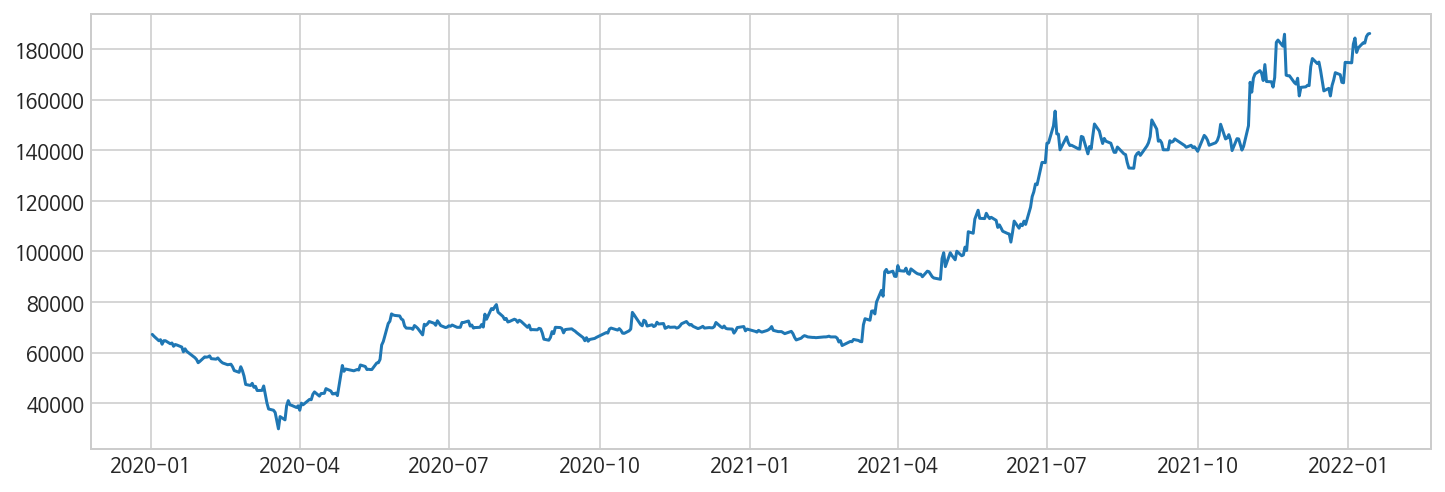

In [64]:
df_종가 = df[['Close']]
plt.figure(figsize=(12,4))
plt.plot(df_종가)
plt.show()

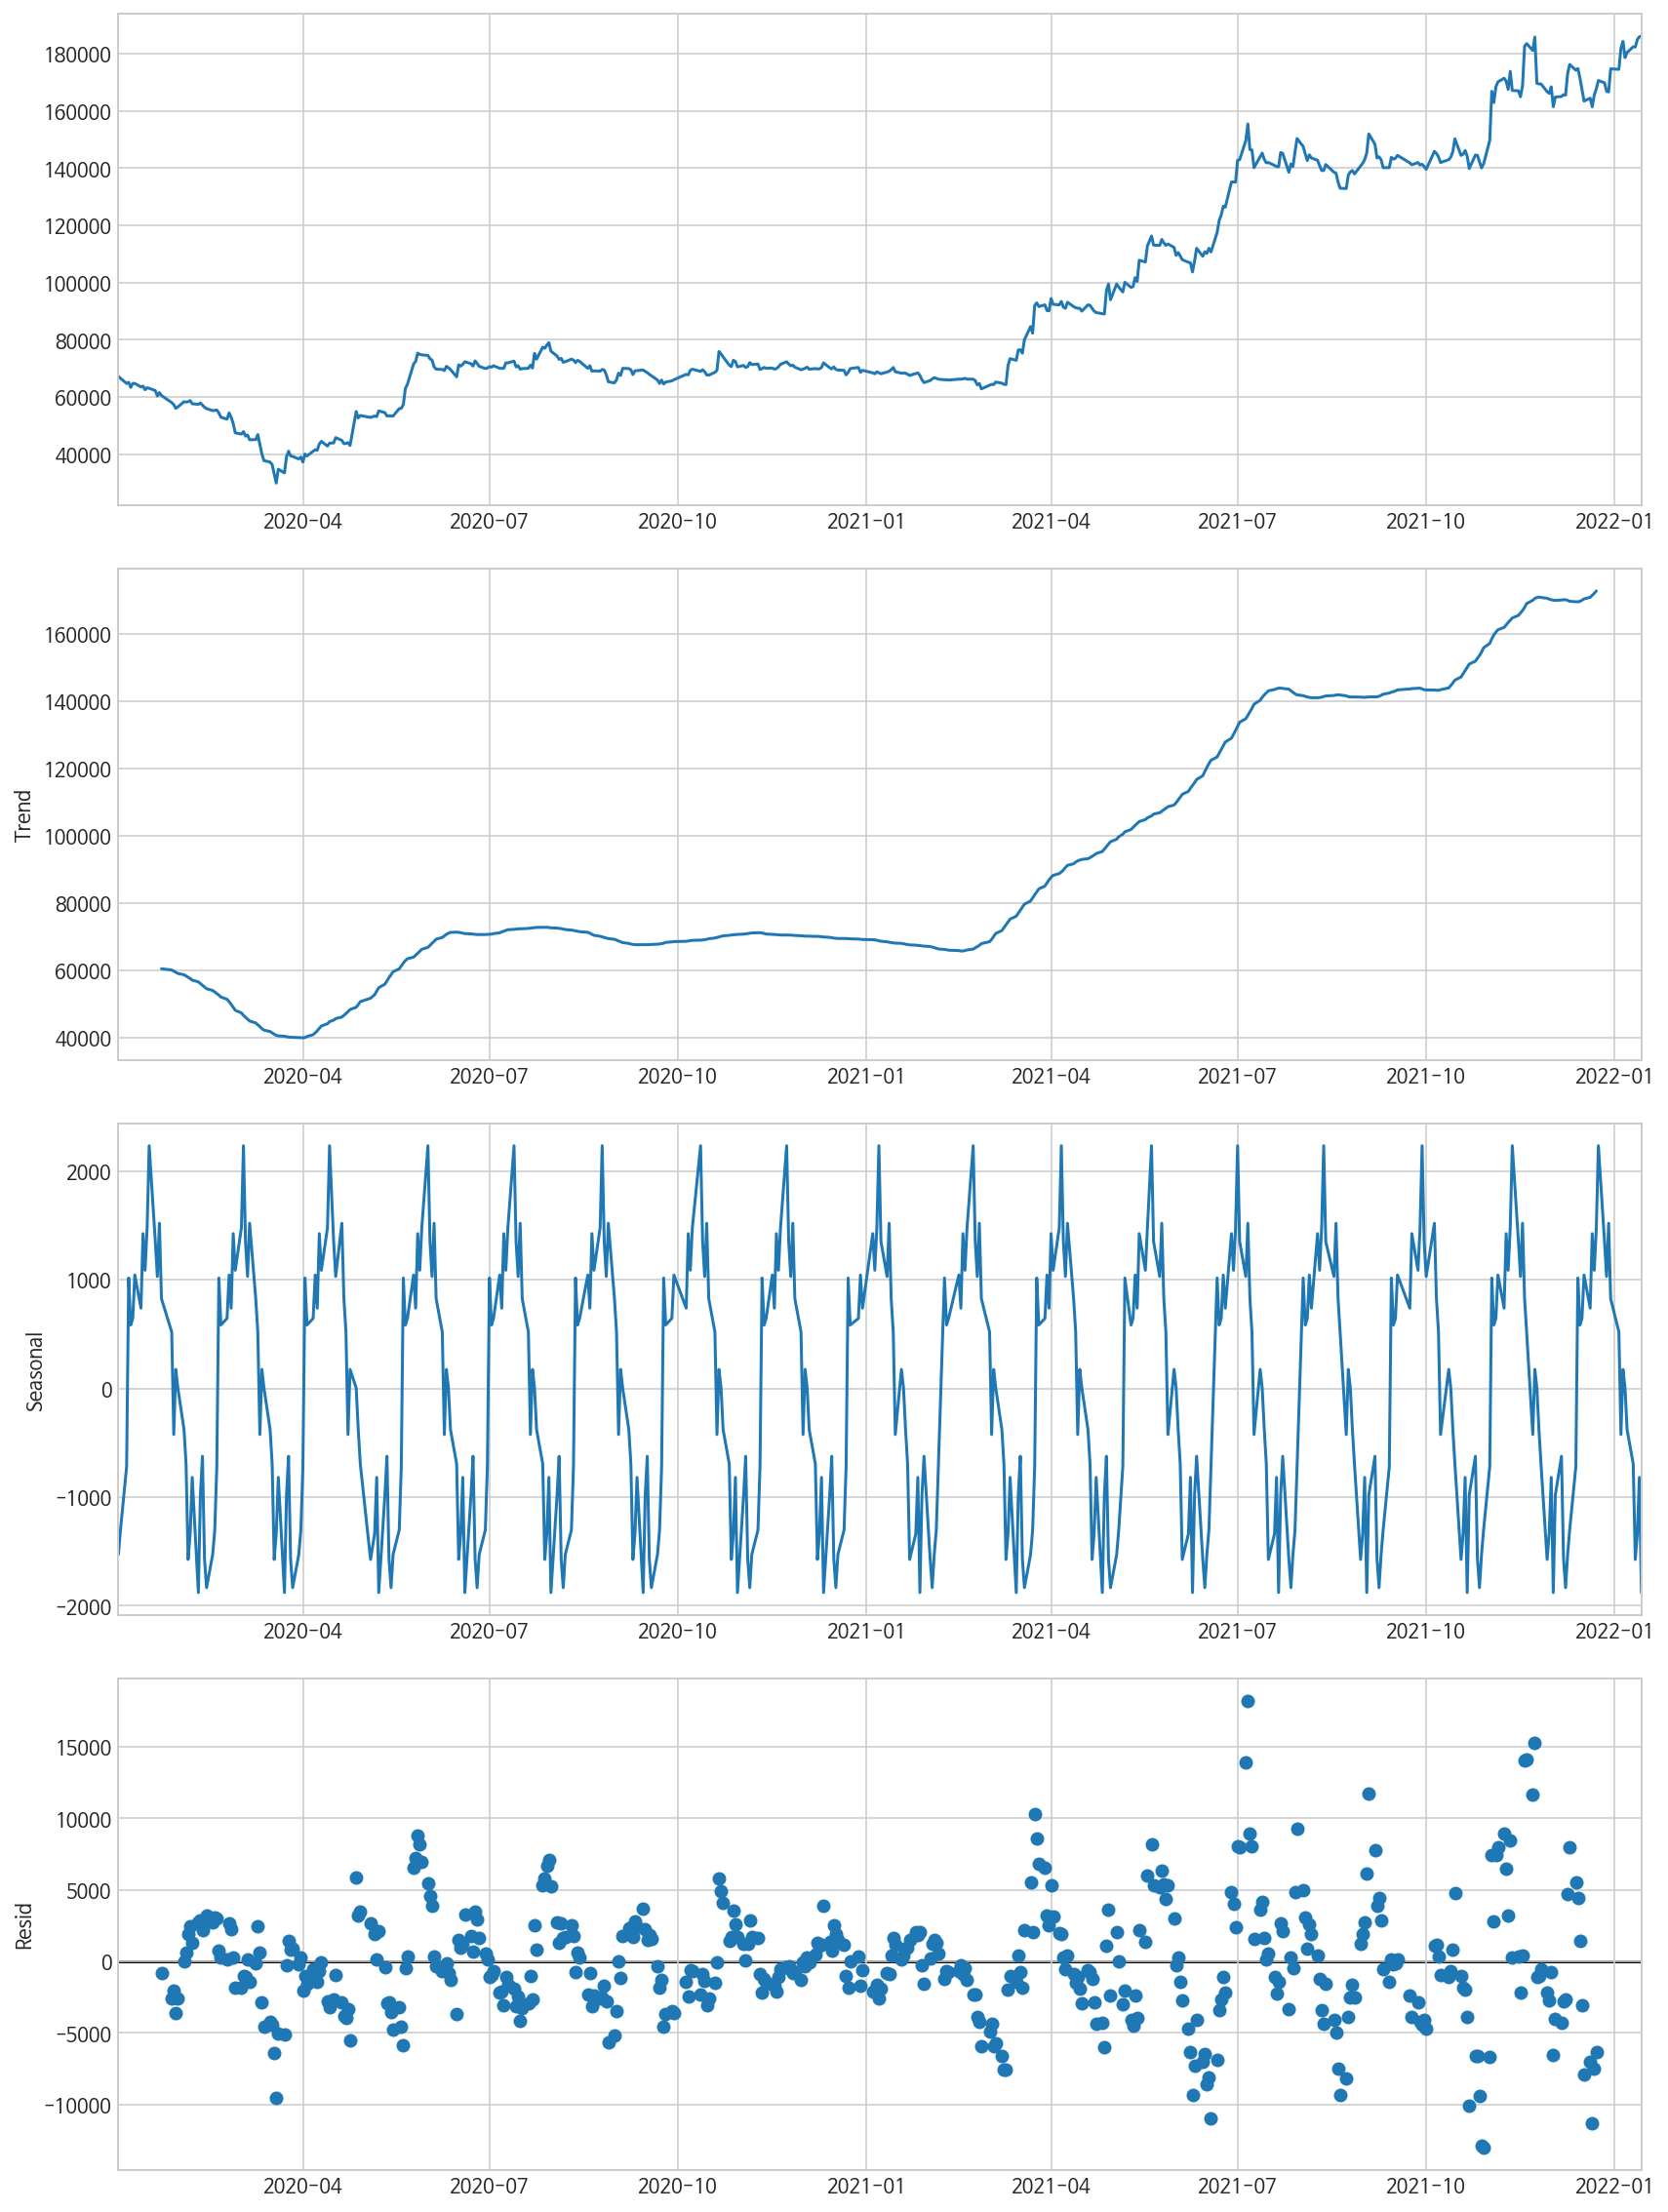

In [65]:
# Seasonal decomposition plot: Seasonal decomposition using moving averages.
# https://www.statsmodels.org/v0.12.0/generated/statsmodels.tsa.seasonal.seasonal_decompose.html?highlight=decompo#statsmodels.tsa.seasonal.seasonal_decompose

# Observed: observed data
# Trend: The estimated trend component
# Seasonal: The estimated seasonal component
# resid: The estimated residuals

df_종가_decomposition = sm.tsa.seasonal_decompose(df_종가, model='additive', period=30)
fig = df_종가_decomposition.plot()
fig.set_size_inches(12, 16)
plt.show()

In [66]:
df_KOSPI_종가 = df_KOSPI[['Close']]
df_KOSPI_종가_decomposition = sm.tsa.seasonal_decompose(df_KOSPI_종가, model='additive', period=30)

## 등락

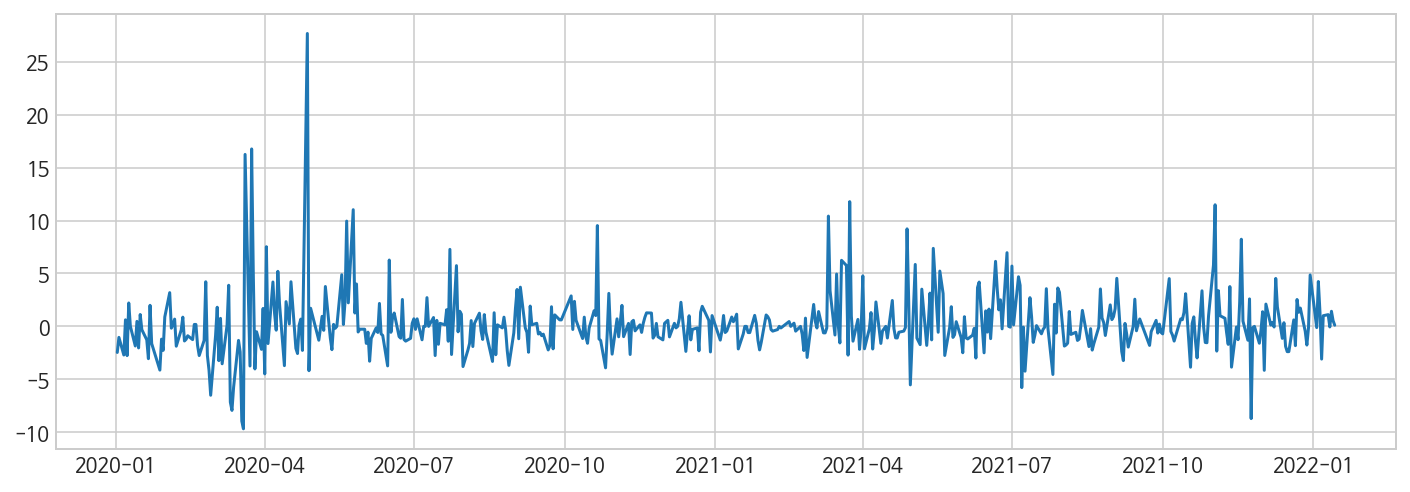

In [67]:
df_등락 = df[['Change']]
plt.figure(figsize=(12,4))
plt.plot(df_등락)
plt.show()

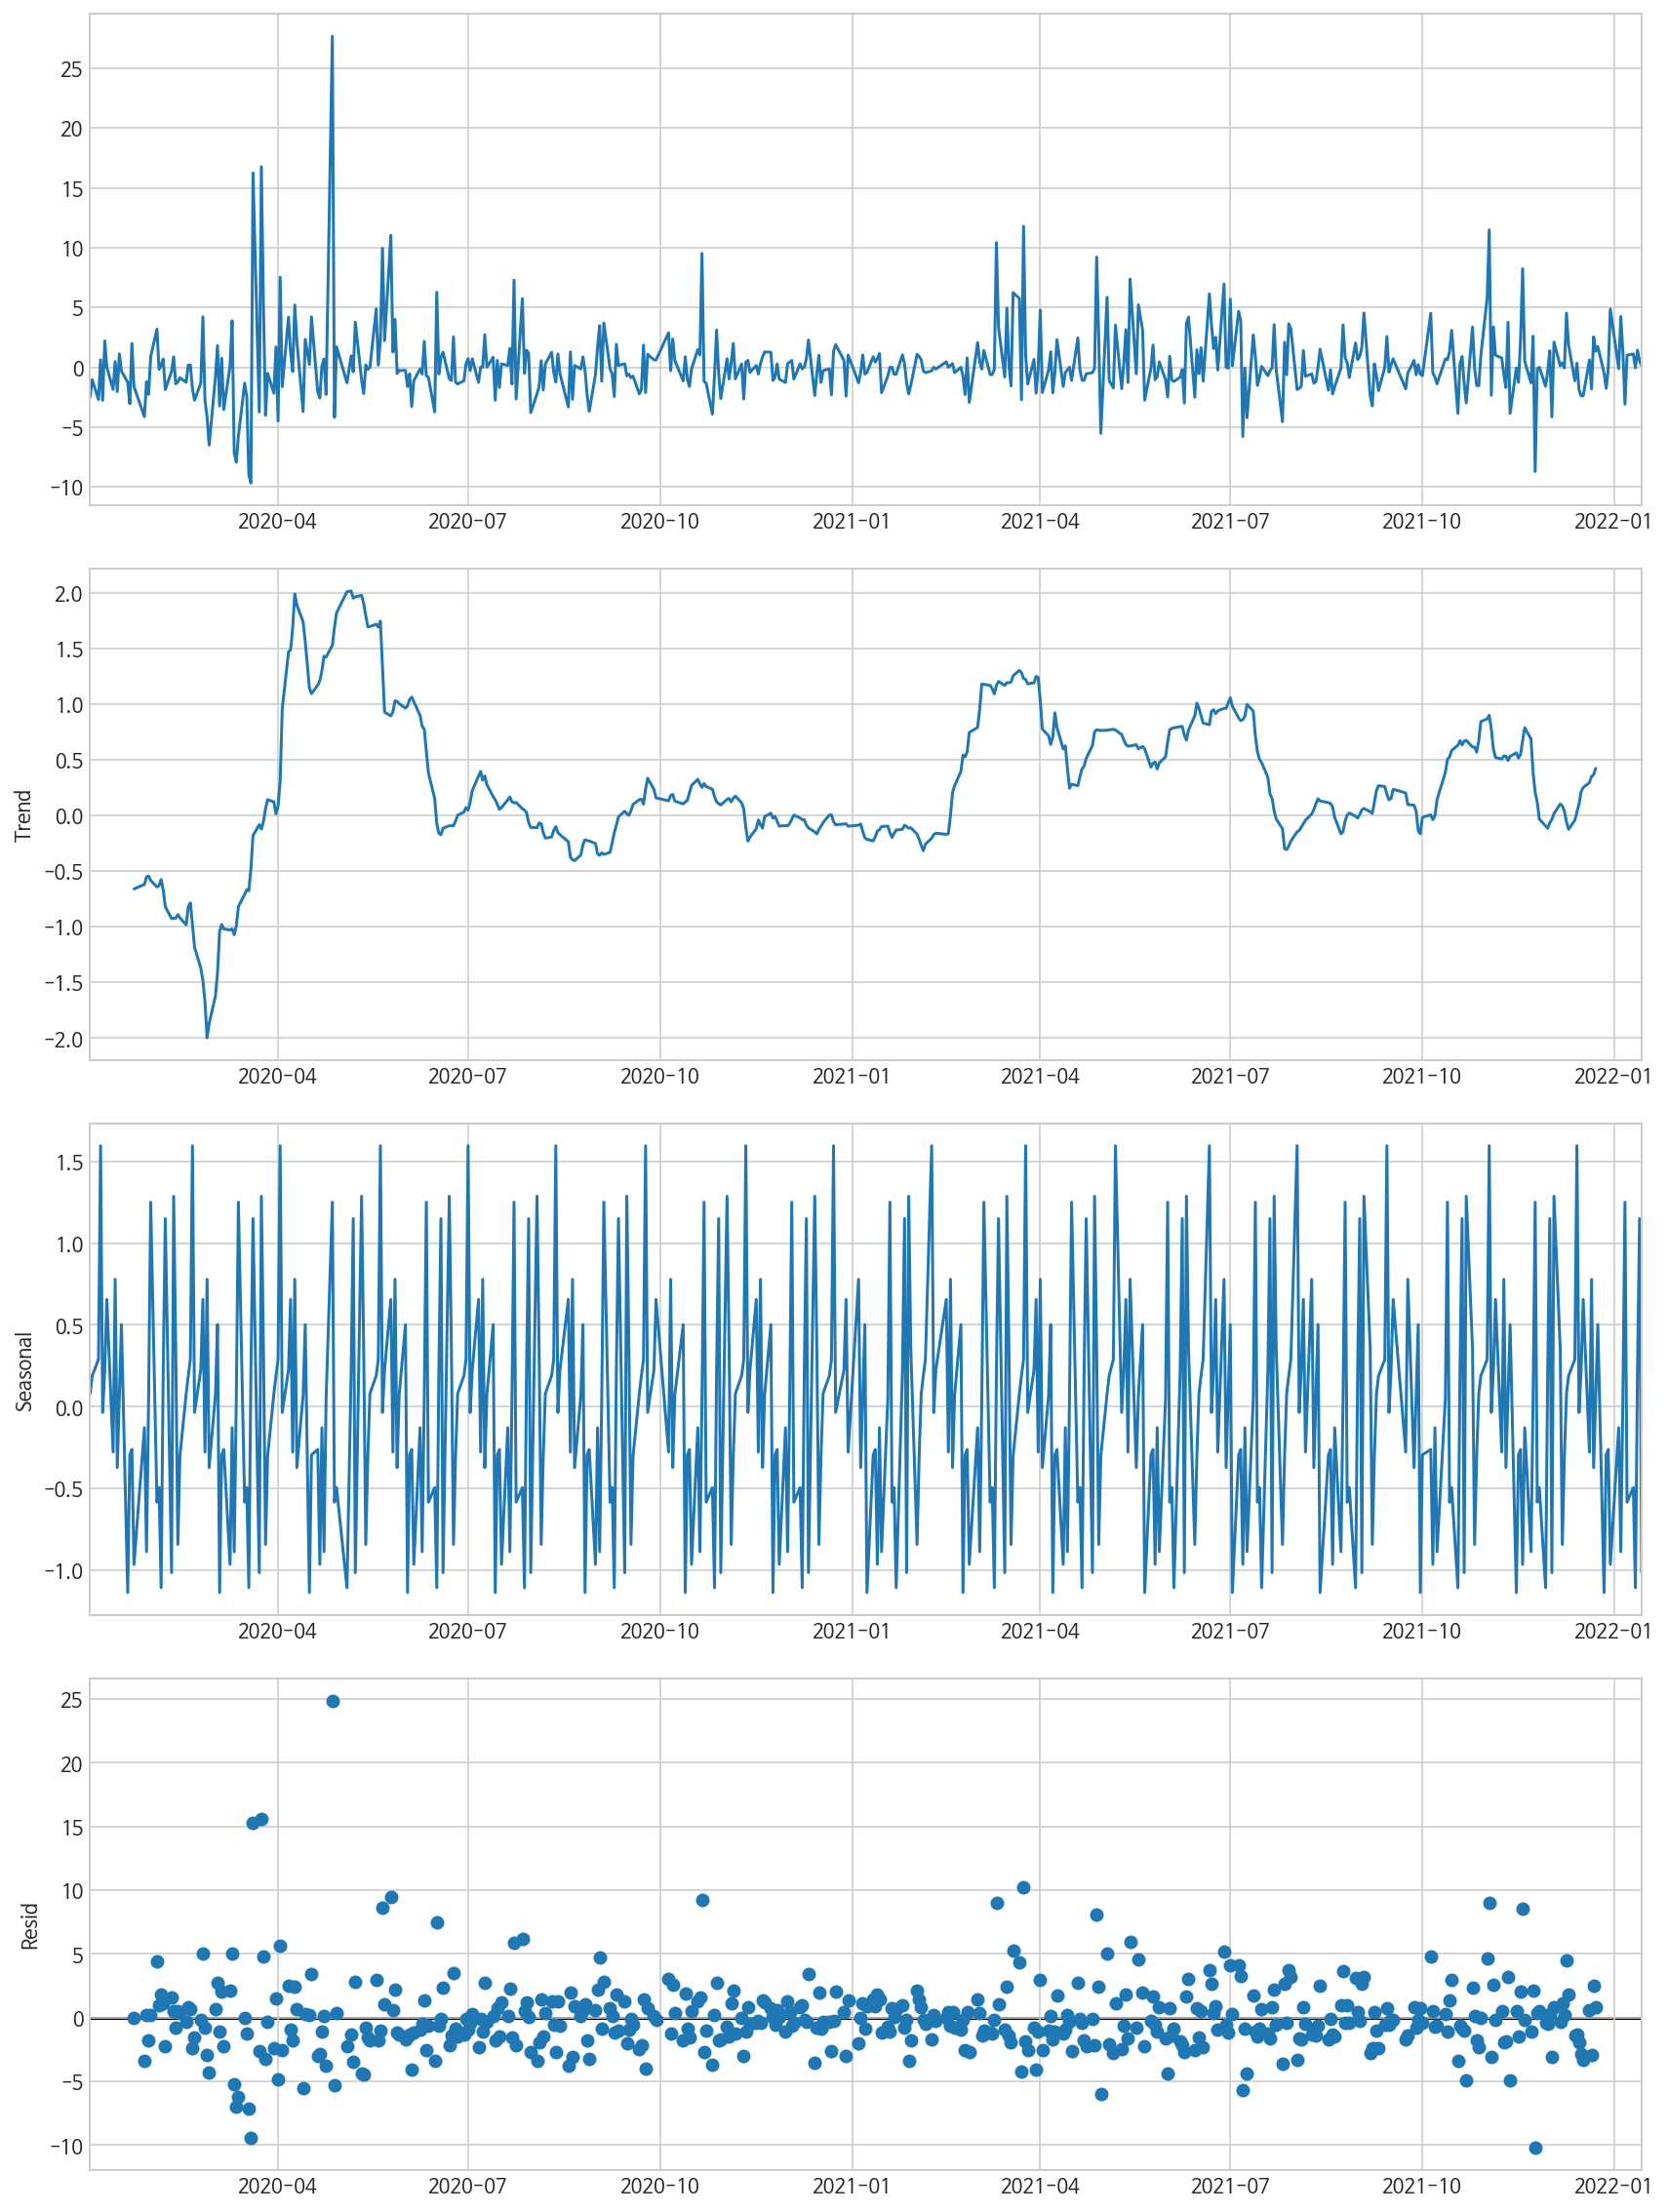

In [68]:
df_등락_decomposition = sm.tsa.seasonal_decompose(df_등락, model='additive', period=30)
fig = df_등락_decomposition.plot()
fig.set_size_inches(12, 16)
plt.show()

## 거래량

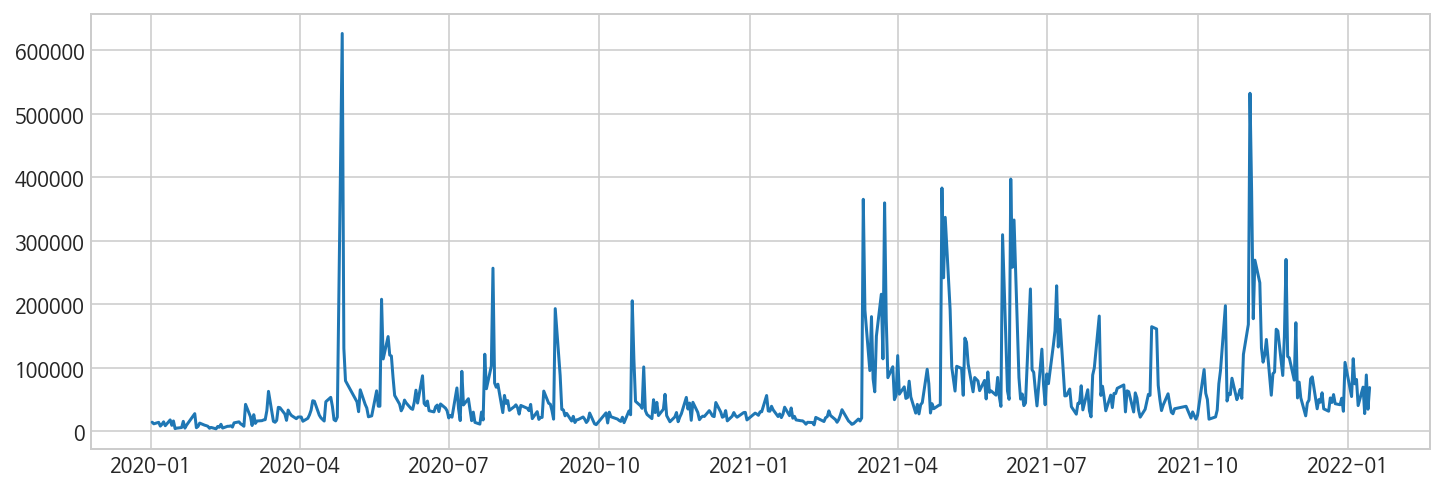

In [69]:
df_거래량 = df[['Volume']]
plt.figure(figsize=(12,4))
plt.plot(df_거래량)
plt.show()

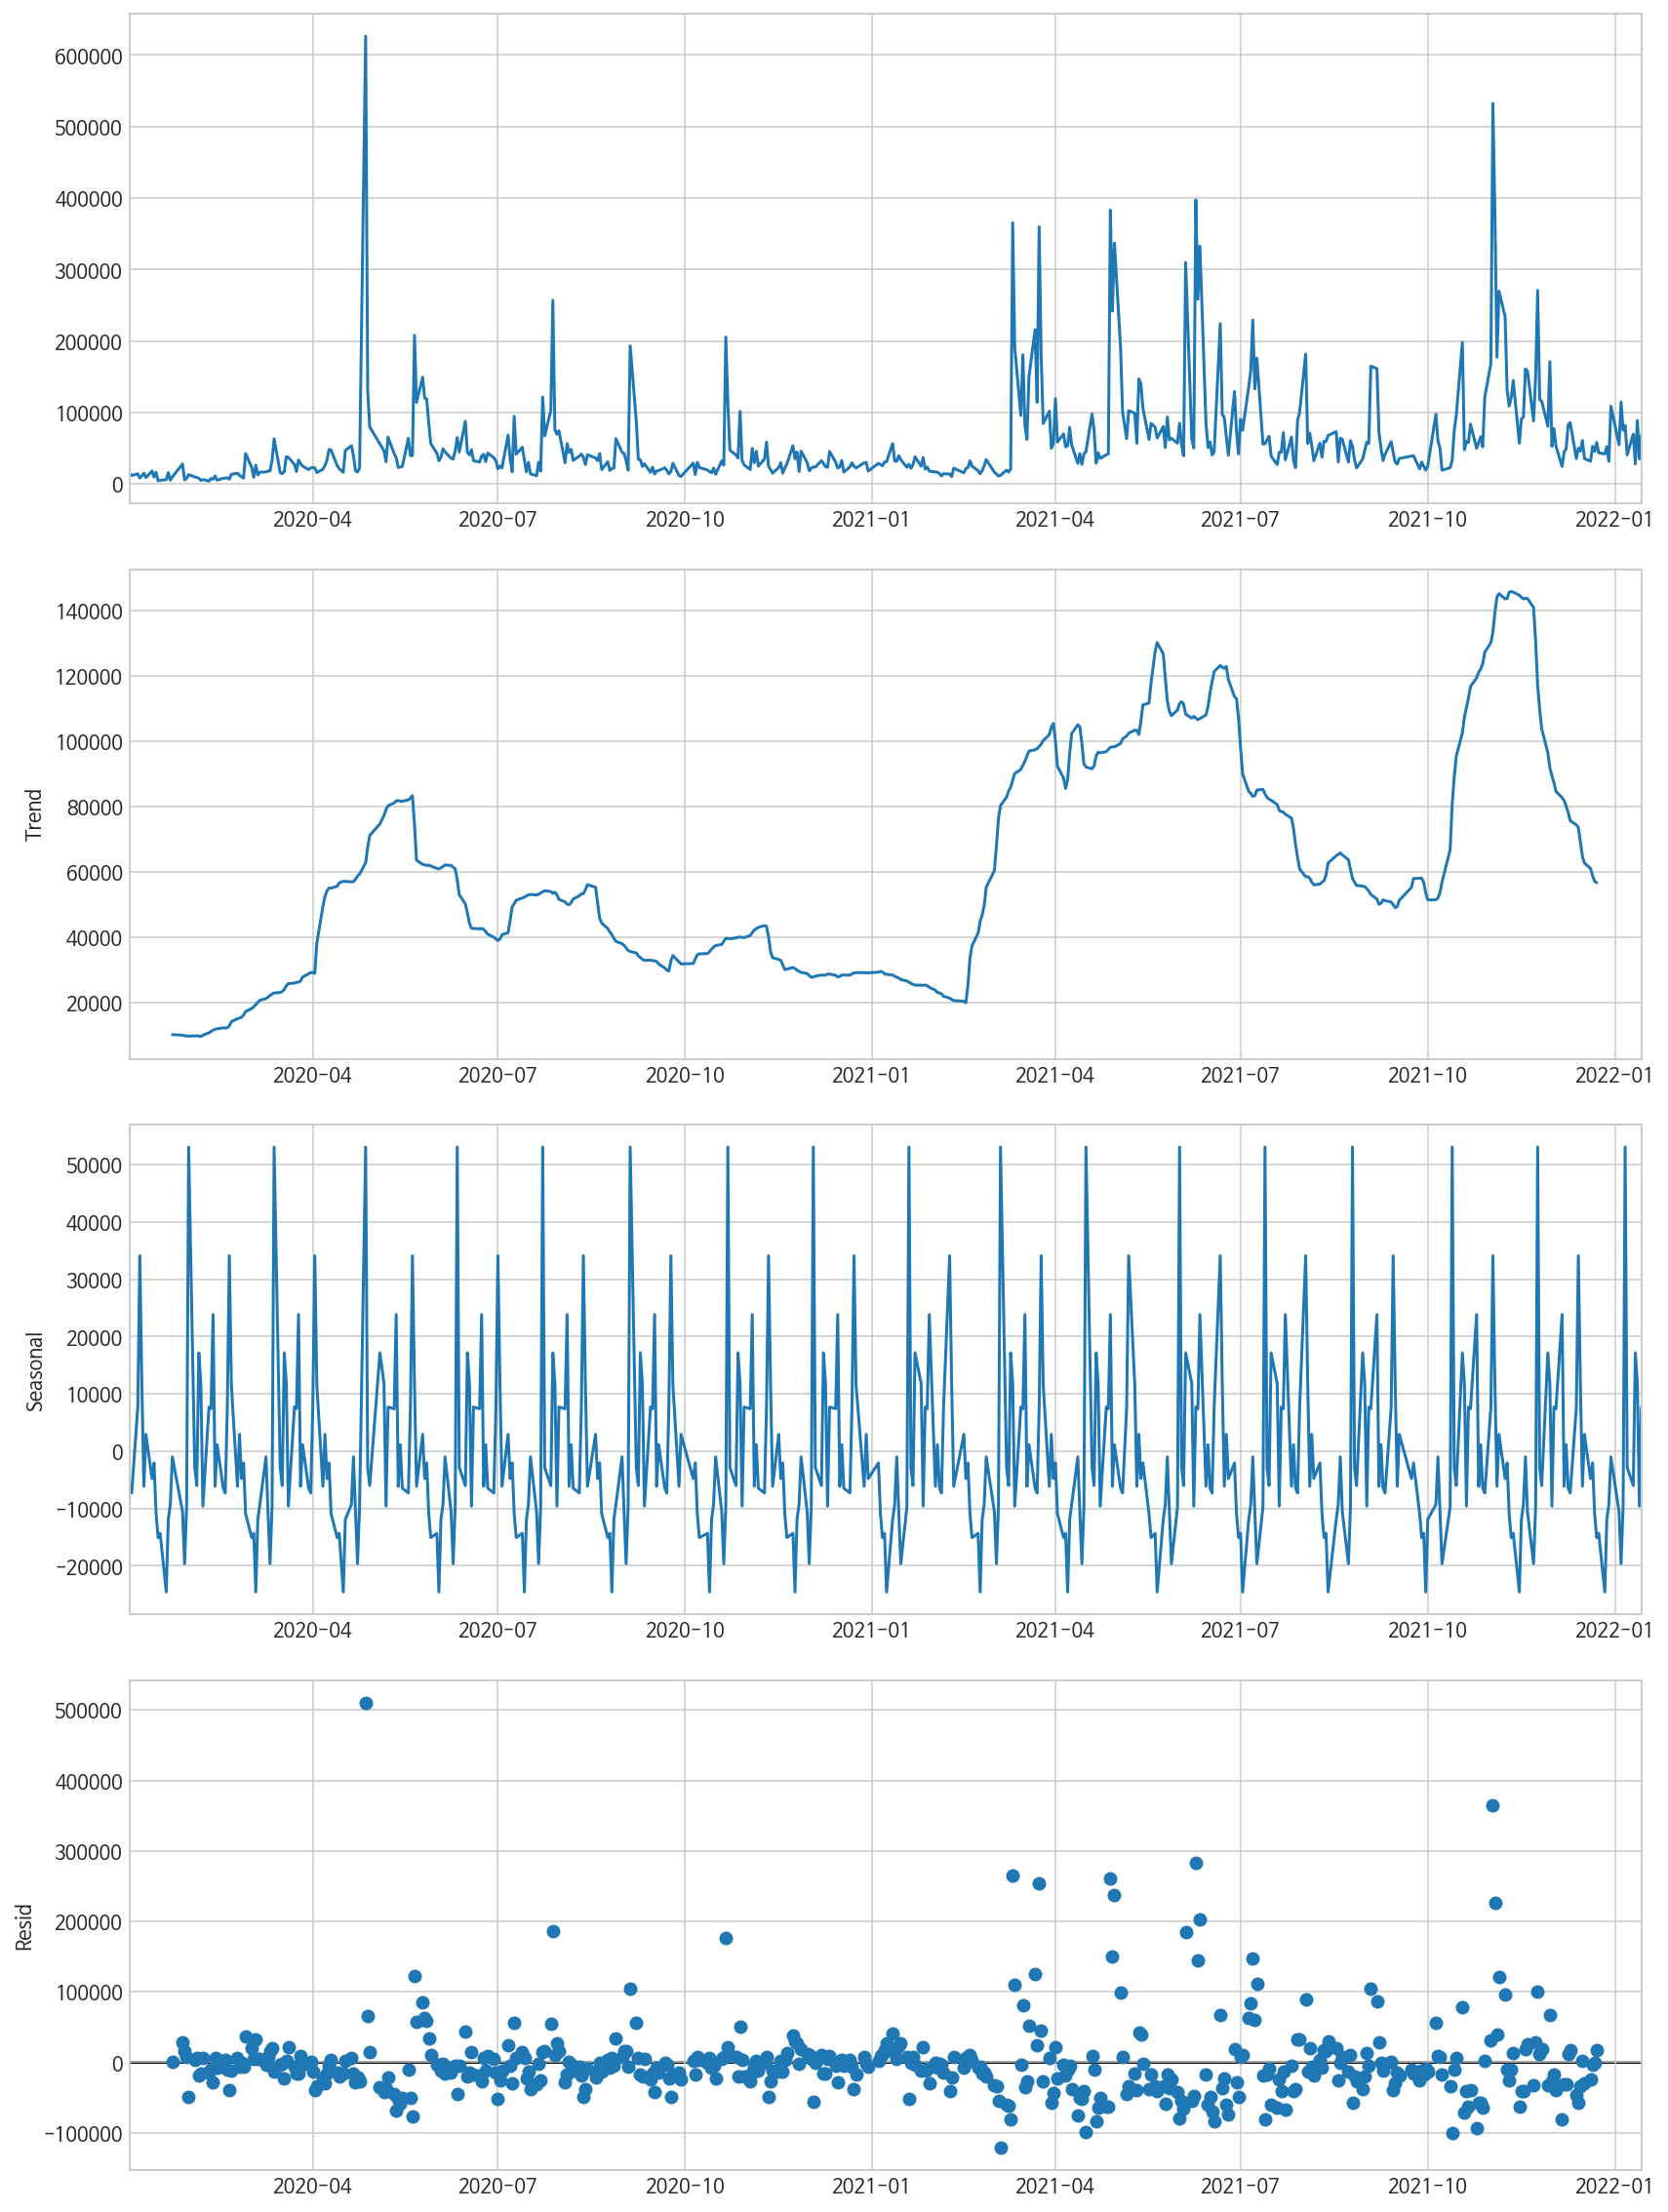

In [70]:
df_거래량_decomposition = sm.tsa.seasonal_decompose(df_거래량, model='additive', period=30)
fig = df_거래량_decomposition.plot()
fig.set_size_inches(12, 16)
plt.show()

## 검색량

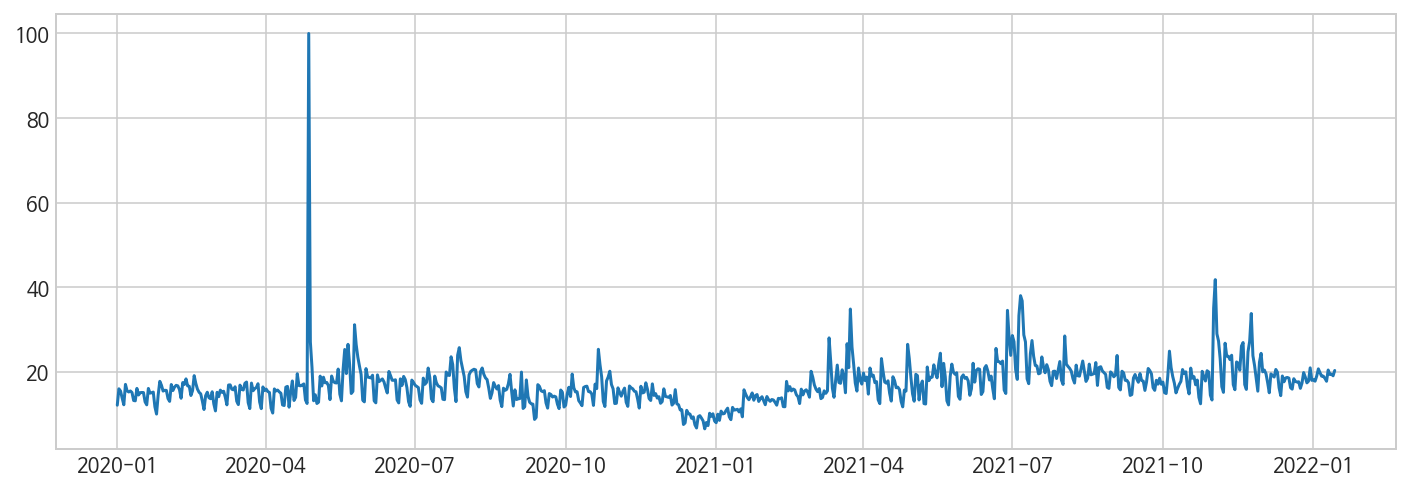

In [71]:
plt.figure(figsize=(12,4))
plt.plot(df_검색량)
plt.show()

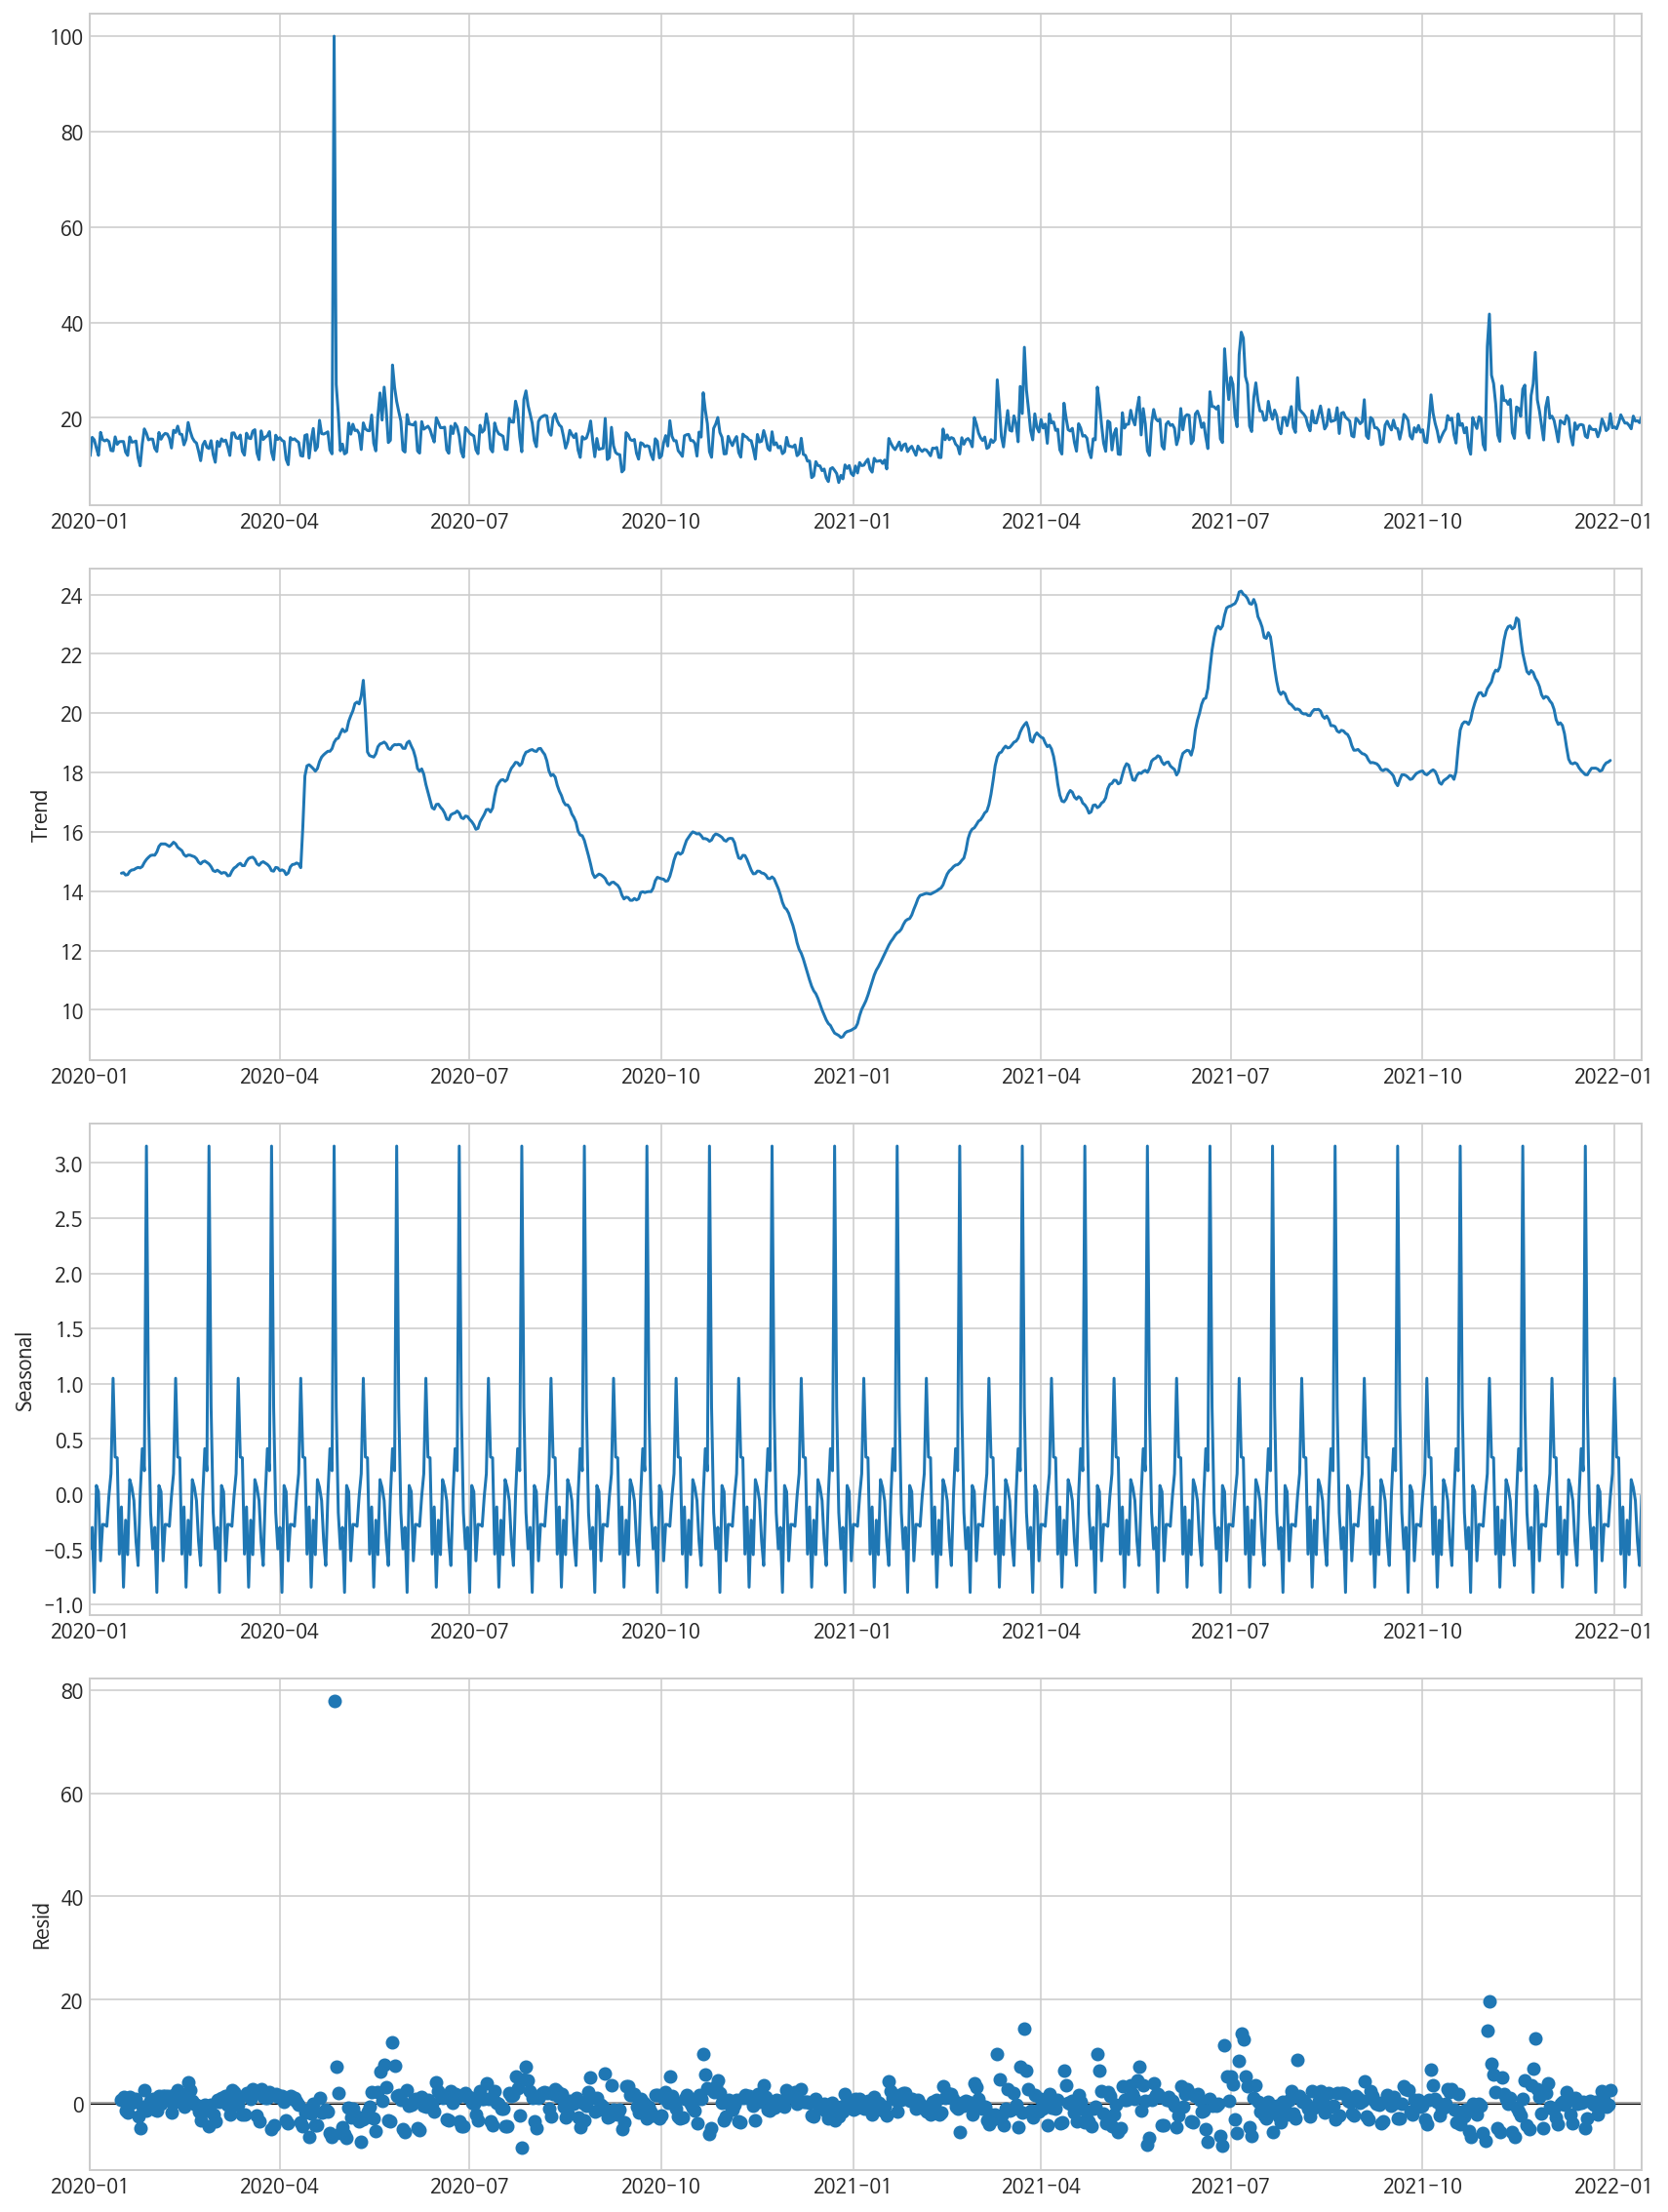

In [72]:
df_검색량_decomposition = sm.tsa.seasonal_decompose(df_검색량, model='additive', period=30)
fig = df_검색량_decomposition.plot()
fig.set_size_inches(12, 16)
plt.show()

## 종합 비교

### 변수 목록

In [139]:
# df

# df_KOSPI_종가_decomposition

# df_종가
# df_종가_decomposition

# df_등락
# df_등락_decomposition

# df_거래량
# df_거래량_decomposition

# df_검색량
# df_검색량_decomposition

### 거래량 많은 날

In [140]:
volume_top = df_거래량.sort_values(by='Volume', ascending=False)
volume_top.reset_index(inplace=True)
volume_top

,Date,Volume
0,2020-04-27,626528
1,2021-11-02,532436
2,2021-06-09,397340
3,2021-04-28,383264
4,2021-11-03,377752
...,...,...
501,2020-01-22,5303
502,2020-01-17,5229
503,2020-02-06,5010
504,2020-01-16,4488


In [141]:
volume_top = volume_top['Date'].apply(lambda x : str(x)[:11])
volume_top = volume_top.unique()[:11]   # 개수 지정
volume_top

array(['2020-04-27 ', '2021-11-02 ', '2021-06-09 ', '2021-04-28 ',
       '2021-11-03 ', '2021-03-11 ', '2021-03-24 ', '2021-04-30 ',
       '2021-06-11 ', '2021-06-04 ', '2021-11-24 '], dtype=object)

### 검색량 높은 날

In [142]:
search_top = df_검색량.sort_values(by='Search_ratio', ascending=False)
search_top.reset_index(inplace=True)
search_top

,Date,Search_ratio
0,2020-04-27,100.00000
1,2021-11-02,41.75110
2,2021-07-06,37.95721
3,2021-07-07,36.71353
4,2021-11-01,34.99594
...,...,...
740,2020-12-12,7.46995
741,2020-12-19,7.41497
742,2020-12-27,7.21598
743,2020-12-20,6.64781


In [143]:
search_top = search_top['Date'].apply(lambda x : str(x)[:11])
search_top = search_top.unique()[:2]   # 개수 지정
search_top

array(['2020-04-27 ', '2021-11-02 '], dtype=object)

### 매매 내역 또는 특이시점

In [144]:
my = pd.read_excel(r'/content/drive/MyDrive/python/16. Time Series analysis/주식/매매 데이터.xlsx')
my

,거래일자,종목,매수/매도,거래금액,거래수량,거래단가
0,2021-11-26,골프존,매수,1866700,11,169700
1,2021-11-26,한일홀딩스,매도,291500,22,13250
2,2021-11-26,한일홀딩스,매도,1689600,128,13200
3,2021-11-19,NHN,매수,976000,10,97600
4,2021-11-19,GST,매수,1063500,30,35450
...,...,...,...,...,...,...
123,2020-09-09,KB금융,매도,379000,10,37900
124,2020-08-04,KB금융,매수,354500,10,35450
125,2020-08-04,신한지주,매수,304500,10,30450
126,2020-08-03,SK하이닉스,매수,833000,10,83300


In [145]:
buy = my[(my['종목'] == 종목) & (my['매수/매도'] == '매수')]
buy = buy['거래일자'].apply(lambda x : str(x)[:11]).unique()

In [146]:
buy

array(['2021-11-26 ', '2021-11-09 ', '2021-11-08 ', '2021-11-05 '],
      dtype=object)

In [147]:
sell = my[(my['종목'] == 종목) & (my['매수/매도'] == '매도')]
sell = sell['거래일자'].apply(lambda x : str(x)[:11]).unique()

In [148]:
sell

array([], dtype='datetime64[ns]')

### 시각화

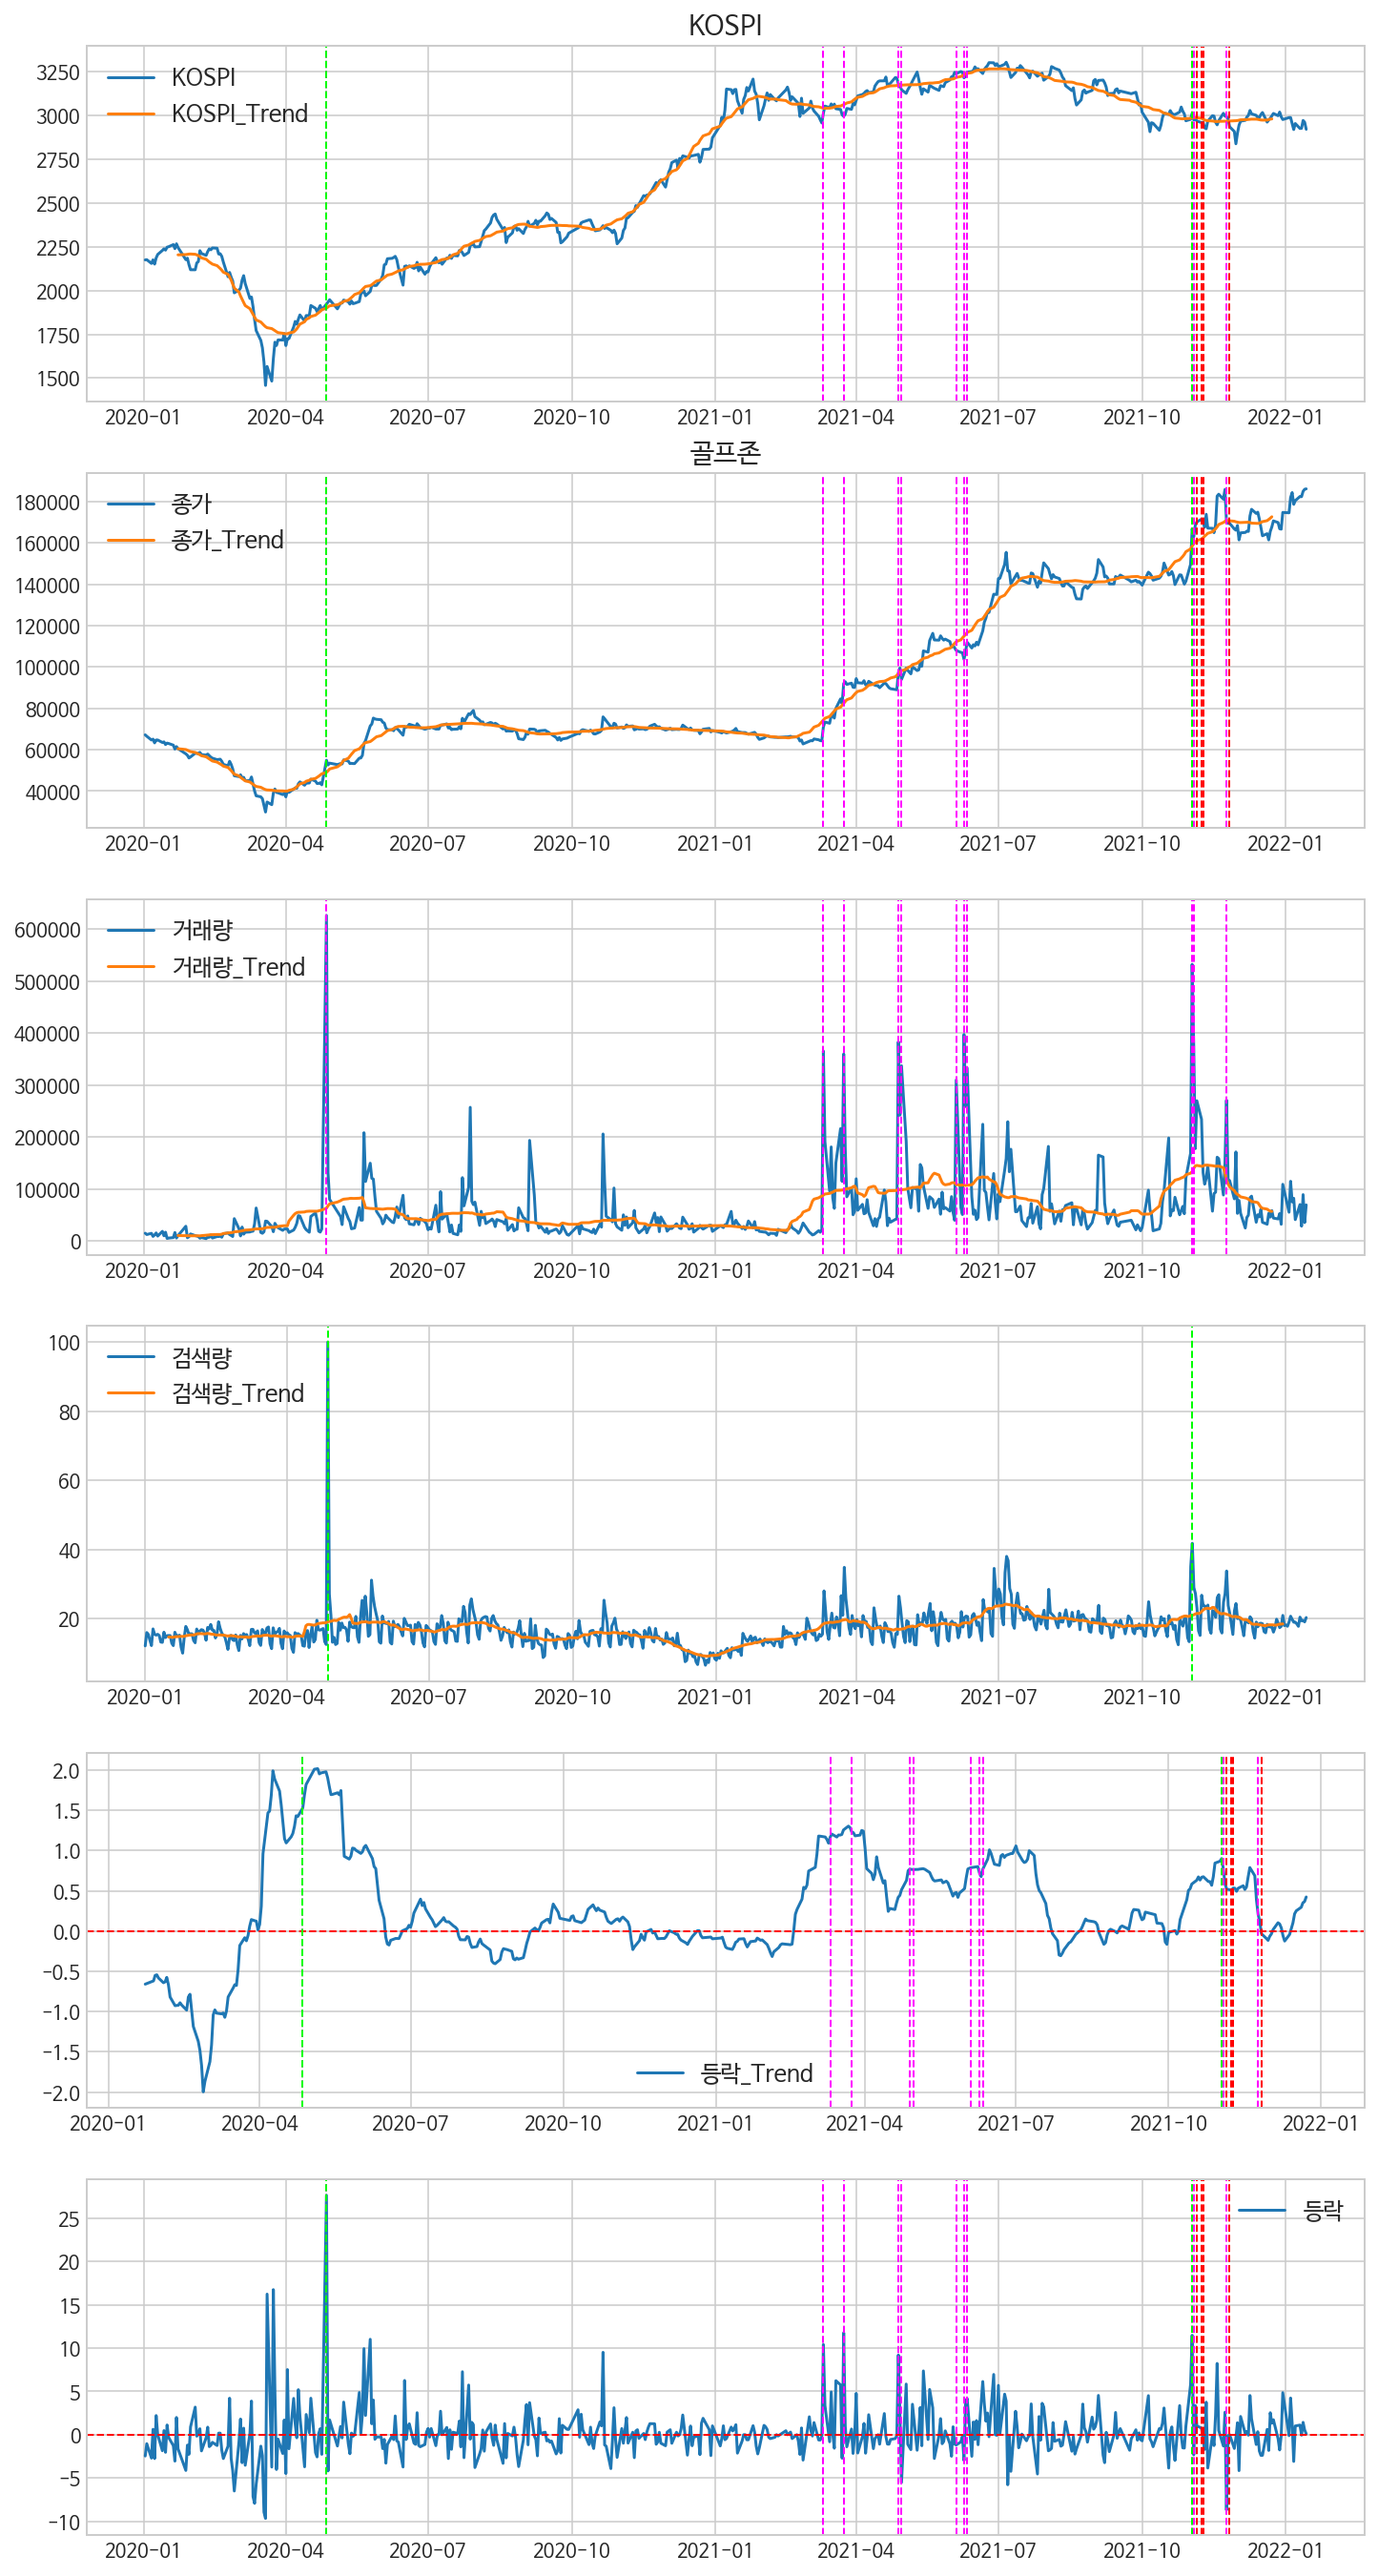

In [150]:
plt.figure(figsize=(12,24))
plt.subplot(6,1,1)
plt.plot(df_KOSPI_종가, label='KOSPI')
plt.plot(df_KOSPI_종가_decomposition.trend, label='KOSPI_Trend')
for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.title('KOSPI', fontsize=14)
plt.legend(fontsize=12)

plt.subplot(6,1,2)
plt.plot(df_종가, label='종가')
plt.plot(df_종가_decomposition.trend, label='종가_Trend')
for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.title(종목, fontsize=14)
plt.legend(fontsize=12)

plt.subplot(6,1,3)
plt.plot(df_거래량, label='거래량')
plt.plot(df_거래량_decomposition.trend, label='거래량_Trend')
for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
# for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
# for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
# for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.legend(fontsize=12)

plt.subplot(6,1,4)
plt.plot(df_검색량, label='검색량')
plt.plot(df_검색량_decomposition.trend, label='검색량_Trend')
# for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
# for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
# for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.legend(fontsize=12)

plt.subplot(6,1,5)
plt.plot(df_등락_decomposition.trend, label='등락_Trend')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.legend(fontsize=12)

plt.subplot(6,1,6)
plt.plot(df_등락, label='등락')
plt.axhline(y=0, color='r', linestyle='--', linewidth=1)
for v in volume_top : plt.axvline(x=v, color='fuchsia', linestyle='--', linewidth=1)
for s in search_top : plt.axvline(x=s, color='lime', linestyle='--', linewidth=1)
for b in buy : plt.axvline(x=b, color='red', linestyle='--', linewidth=1)
for s in sell : plt.axvline(x=s, color='blue', linestyle='--', linewidth=1)
plt.legend(fontsize=12)
plt.show()